In [1]:
from ast import mod
import torch
from torch.nn import Module, Linear, Conv2d, MaxPool2d, LeakyReLU, Sequential, BatchNorm2d, Sigmoid, ConvTranspose2d
from torch import nn


def create_conv_module(in_channels, out_channels, kernel_size=3, stride=2):
    module = Sequential(
        Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=1, bias=False),
        BatchNorm2d(num_features=out_channels),
        LeakyReLU()
    )
    return module 

def create_trans_conv_module(in_channels, out_channels, kernel_size=3, stride=1, padding=0):
    module = Sequential(
        ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
        BatchNorm2d(num_features=out_channels),
        LeakyReLU()
    )
    return module        

class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.sequential = Sequential(
            create_conv_module(in_channels=1, out_channels=4, kernel_size=4),
            create_conv_module(in_channels=4, out_channels=8, kernel_size=3), 
            create_conv_module(in_channels=8, out_channels=16, kernel_size=3), 
            Conv2d(in_channels=16, out_channels=1, kernel_size=4, stride=1), 
            Sigmoid()
        )

    def forward(self, x):
        return self.sequential(x).view(-1)

class Generator(Module):

    def __init__(self, in_channels=64) -> None:
        super().__init__()
        self.sequential = Sequential(
            create_trans_conv_module(in_channels=100, out_channels=128, kernel_size=4),
            create_trans_conv_module(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1),
            create_trans_conv_module(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, bias=False, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.sequential(x)        


/home/daniel/mambaforge/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import PILToTensor, ConvertImageDtype, Compose

img_transforms = Compose([
    PILToTensor(),
    ConvertImageDtype(torch.float)
])

root_dir = './data/mnist/'
train_dataset = MNIST(root=root_dir+'train', train=True, download=True, transform=img_transforms)
test_dataset = MNIST(root=root_dir+'test', train=False, download=True, transform=img_transforms)


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=20)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=20)


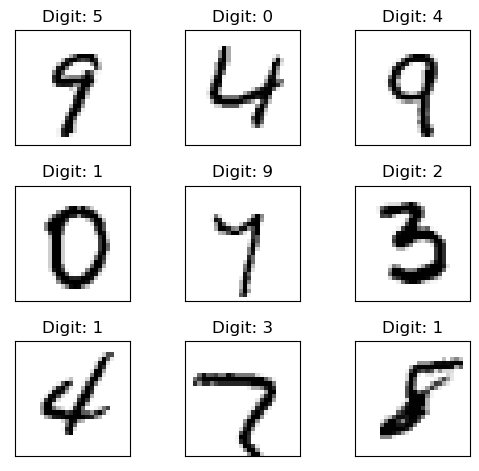

In [3]:
#show some images
import matplotlib.pyplot as plt
import numpy as np
batch_imgs, batch_labels = next(iter(train_loader))
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(batch_imgs[i].view(28,28), cmap='binary', interpolation='none')
    plt.title("Digit: {}".format(train_dataset[i][1]))
    plt.xticks([])
    plt.yticks([])


In [4]:
def sample_from_latent(n_samples):
    return torch.randn(size=(n_samples, 100, 1, 1))

#### Train Deep Convolutional GAN on MNIST

* Instantiate the generator and discriminator
* Create the optimizers
* Create the loss functions
* Iterate over the batches of the dataloarder
* Update the weights (optimizer step)
* Compute the losses and generate images

In [32]:
from tqdm.auto import tqdm



def compute_loss(pred, target):
    return torch.nn.functional.binary_cross_entropy(pred, target)  
      
 
class Trainner():
    def __init__(self, generator, discriminator, train_loader, test_loader):
        self.generator = generator
        self.discriminator = discriminator
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.losses = []
        self.losses_gen = []

        self.discriminator.to(self.device)
        self.generator.to(self.device)

        self.optimizer_G = torch.optim.Adam(self.generator.parameters())
        self.optimizer_D = torch.optim.Adam(self.discriminator.parameters())

    def discriminator_step(self, img_batch, labels_batch):
        self.optimizer_D.zero_grad()

        ones = torch.ones(labels_batch.shape).to(self.device)
        zeros = torch.zeros(labels_batch.shape).to(self.device)
        z_input = sample_from_latent(img_batch.shape[0]).to(self.device)

        img_batch = img_batch.to(self.device)
        fake_imgs = self.generator(z_input).detach()

        y_pred = self.discriminator(img_batch)
        y_pred_fake = self.discriminator(fake_imgs)

        loss = compute_loss(y_pred, ones)
        loss += compute_loss(y_pred_fake, zeros)
        loss.backward()

        self.optimizer_D.step()        

        return loss.cpu().item()

    def generator_step(self, labels_batch, img_batch):
        self.optimizer_G.zero_grad()

        ones = torch.ones(labels_batch.shape).to(self.device)
        z_input = sample_from_latent(img_batch.shape[0]).to(self.device)

        fake_imgs = self.generator(z_input)
        y_pred_fake = self.discriminator(fake_imgs)
        loss = compute_loss(y_pred_fake, ones)
        loss.backward()

        self.optimizer_G.step()
        return loss.cpu().item()    

    def train_discriminator(self, epochs = 1):
        progress_bar = tqdm(range(epochs*len(train_loader)))
        self.discriminator.train()
        self.generator.eval()

        for epoch in range(epochs):
            for img_batch, labels_batch in train_loader:
                loss = self.discriminator_step(img_batch, labels_batch)
                self.losses.append(loss)
                progress_bar.update(1)

    def train_generator(self, epochs = 1):
        progress_bar = tqdm(range(epochs*len(train_loader)))
        self.discriminator.eval()
        self.generator.train() 
        for epoch in range(epochs):
            for img_batch, labels_batch in train_loader:
                loss = self.generator_step(labels_batch, img_batch)
                self.losses_gen.append(loss)
                progress_bar.update(1)

    def train_both(self, epochs = 1, train_gen_every = 1):
        progress_bar = tqdm(range(epochs*len(train_loader)))
        for epoch in range(epochs):
            self.discriminator.train()
            self.generator.train()
            for iter, (img_batch, labels_batch) in enumerate(train_loader):
                d_loss = self.discriminator_step(img_batch, labels_batch)
                if iter % train_gen_every == 0:
                    g_loss = self.generator_step(labels_batch, img_batch)
                progress_bar.update(1)
                self.losses.append(d_loss)
                self.losses_gen.append(g_loss)


In [16]:
trainer = Trainner(Generator(), Discriminator(), train_loader, test_loader)

In [33]:
trainer2 = Trainner(trainer.generator, trainer.discriminator, train_loader, test_loader)

In [28]:
trainer.train_discriminator(epochs=1)

100%|██████████| 1875/1875 [00:09<00:00, 187.54it/s]


In [47]:
trainer2.train_both(epochs=5, train_gen_every=1)

100%|██████████| 9375/9375 [01:24<00:00, 110.48it/s]


In [39]:
trainer2.train_generator(epochs=1)

100%|██████████| 1875/1875 [00:09<00:00, 205.23it/s]


Text(0, 0.5, 'Loss')

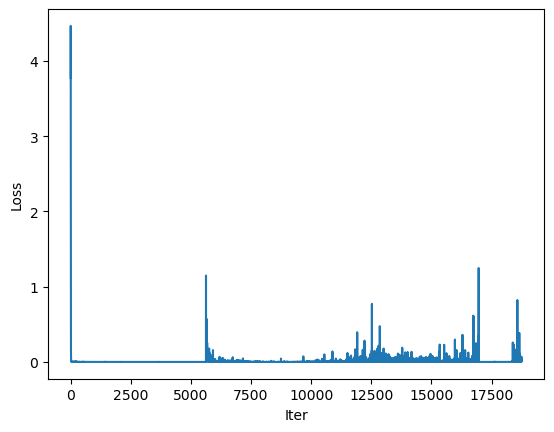

In [48]:
#plot losses
plt.plot(trainer2.losses)
plt.xlabel('Iter')
plt.ylabel('Loss')


Text(0, 0.5, 'Loss')

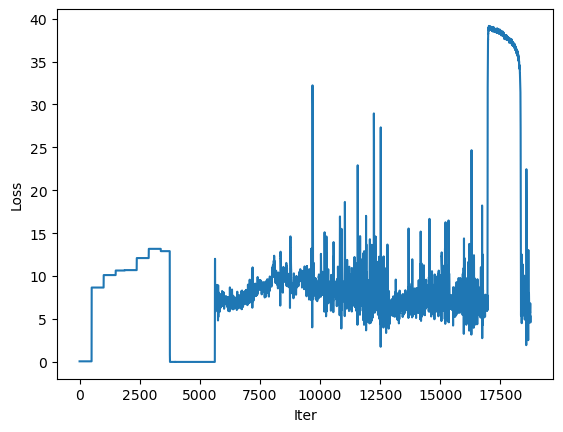

In [49]:
#plot losses
plt.plot(trainer2.losses_gen)
plt.xlabel('Iter')
plt.ylabel('Loss')


In [50]:
trainer2.generator.eval()
z_input = sample_from_latent(3).to(trainer2.device)
fake_imgs = trainer2.generator(z_input)


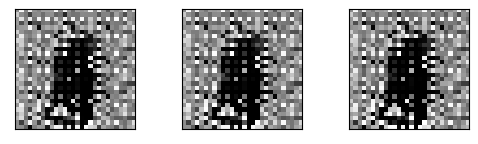

In [51]:
img0 = fake_imgs.detach().cpu().numpy()


#Show images
plt.figure(figsize=(5,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.tight_layout()
    plt.imshow(img0[i].reshape(28,28), cmap='binary', interpolation='none')
    plt.xticks([])
    plt.yticks([])